In [1]:
import torch
from transformers import DPTForDepthEstimation, DPTFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Step 1: Load the image and the model
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def load_model():
    model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-base-384")
    feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-beit-base-384")
    return model, feature_extractor

# Step 2: Obtain depth map
def get_depth_map(image, model, feature_extractor):
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth.squeeze().cpu().numpy()
    return predicted_depth


/opt/homebrew/Caskroom/miniconda/base/envs/ssl-fede/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from scipy.signal import find_peaks

# Function to calculate histogram peaks and dynamically create bins based on peaks
def create_dynamic_depth_bins(depth_map, overlap=0.2, peak_prominence=0.05, bin_width=0.1, bins=100):
    # Calculate histogram of depth values
    depth_hist, bin_edges = np.histogram(depth_map, bins=bins)

    # Identify peaks in the histogram (potential depth layers)
    peaks, _ = find_peaks(depth_hist, prominence=peak_prominence * np.max(depth_hist))

    print(f"Found {len(peaks)} peaks in the histogram.")
    
    # Calculate dynamic bins based on the peak locations
    depth_min, depth_max = np.min(depth_map), np.max(depth_map)
    adjusted_bins = []
    for peak in peaks:
        center = bin_edges[peak]
        width = bin_width * (depth_max - depth_min)
        start = max(depth_min, center - width * (1 + overlap))
        end = min(depth_max, center + width * (1 + overlap))
        adjusted_bins.append((start, end))
        
    return adjusted_bins, depth_hist


In [3]:
import numpy as np
import cv2

def get_boxes(np_image):

    # Find the contours
    contours, hierarchy = cv2.findContours(np_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    colors = [
        (0, 0, 255), # blue
        (0, 255, 0), # green
        (255, 0, 0), # red
        (255, 255, 0), # cyan
        (255, 0, 255), # magenta
        (0, 255, 255), # yellow
        (128, 0, 0), # maroon
        (0, 128, 0), # olive
        (0, 0, 128), # navy
        (128, 128, 0), # teal
        (128, 0, 128), # purple
        (0, 128, 128), # silver
    ]

    the_contours = []

    # Draw the contours with different colors
    for i, contour in enumerate(contours):
        
        # Using hierarchy to filter out the inner contours
        if hierarchy[0][i][3] != -1:
            continue

        # if the contour is too small, ignore it
        if cv2.contourArea(contour) < 1000:
            continue

        # Approximate the contour with a rectangle
        x, y, w, h = cv2.boundingRect(contour)    
        the_contours.append([x, y, w, h])

    return the_contours


# Function to count the number of unique colors in an image
def count_colors(image):
    # convert to 1D array
    reshaped = image.flatten()
    unique = np.unique(reshaped, axis=0)
    print(unique)
    return len(unique)


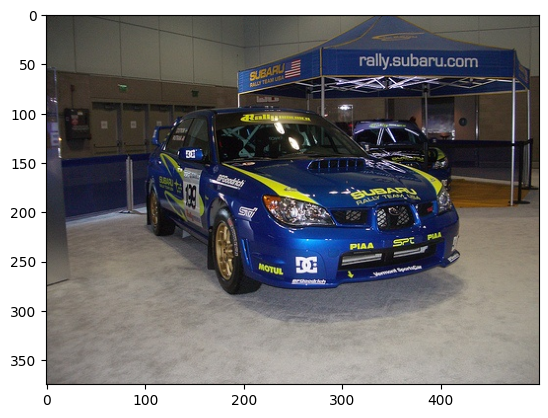

Image shape: (500, 375)


/opt/homebrew/Caskroom/miniconda/base/envs/ssl-fede/lib/python3.12/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


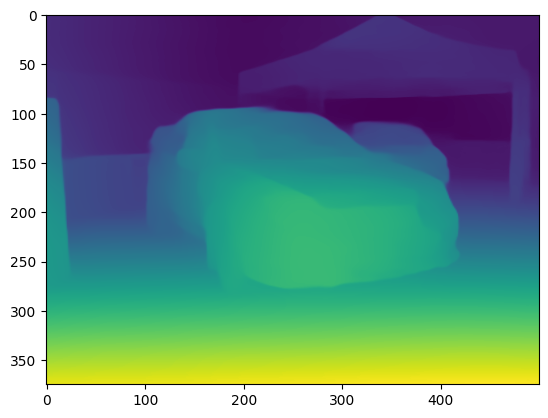

depth_map: 2.2523006e-10 1.0
scaling_mask: 0.5 1.0


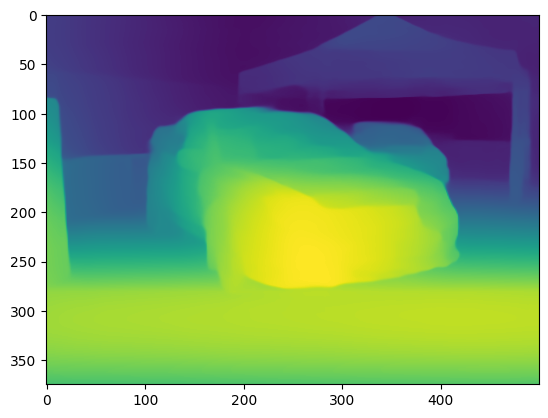

Found 5 peaks in the histogram.
Bins: [(3.1983829e-15, 40.79999797821045), (3.1983829e-15, 56.09999626159668), (10.200001068115235, 71.39999740600587), (51.00000030517578, 112.19999664306641), (196.3499835205078, 254.99998)]


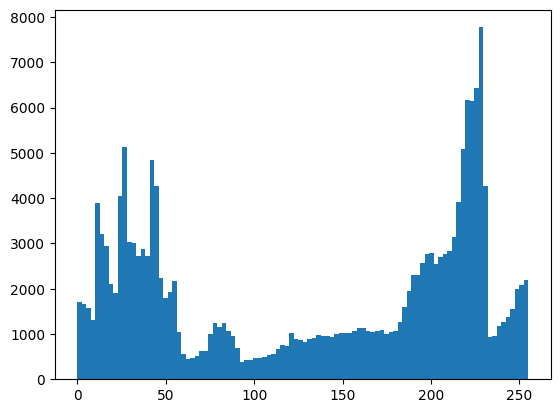

In [4]:
# Use this to run the pipeline
image_path = "datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/001258.jpg"

image = load_image(image_path)

plt.imshow(image)
plt.show()

print("Image shape:", image.size)

model, feature_extractor = load_model()

# Generate depth map
depth_map = get_depth_map(image, model, feature_extractor)

# resize the image to the original size
depth_map = cv2.resize(depth_map, (image.size[0], image.size[1]))

plt.imshow(depth_map)
plt.show()



# Get image dimensions
height, width = depth_map.shape

# Define the vertical region for modification (75% to 100% of height)
start_row = int(height * 0.75)

# Create a scaling mask for the lower 25% of the image
scaling_factor = np.linspace(1, 0.5, height - start_row)  # Scale down from 1 to 0.5
scaling_mask = np.ones((height, width))

# Apply the scaling mask to the target region
for i, factor in enumerate(scaling_factor):
    scaling_mask[start_row + i, :] = factor

# let's normalize the depth map to 0-1
depth_map = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX)

print("depth_map:", depth_map.min(), depth_map.max())
print("scaling_mask:", scaling_mask.min(), scaling_mask.max())

# Apply the mask to scale down the depth values in the target area
modified_depth_map = depth_map * scaling_mask

# Clip values to maintain within valid range for depth data type
modified_depth_map = np.clip(modified_depth_map, 0, np.max(depth_map)).astype(depth_map.dtype)

plt.imshow(modified_depth_map)
plt.show()

depth_map = modified_depth_map.copy()

# normalize the depth map to 0-255
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)


# Assuming depth_map is your depth data array
bins, hist = create_dynamic_depth_bins(depth_map, overlap=0.2, peak_prominence=0.05, bin_width=0.1)

print("Bins:", bins)

plt.hist(depth_map.flatten(), bins=100)
plt.show()


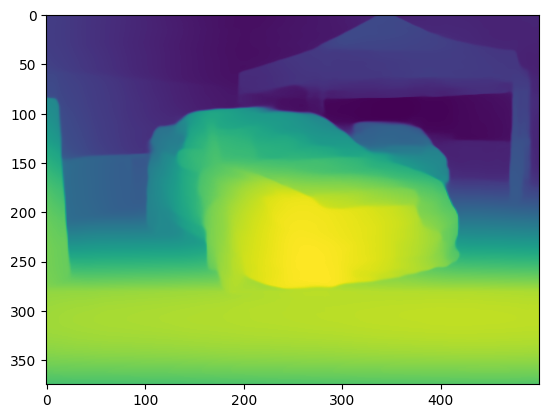

Found 5 peaks in the histogram.
Bins: [(3.1983829e-15, 40.79999797821045), (3.1983829e-15, 56.09999626159668), (10.200001068115235, 71.39999740600587), (51.00000030517578, 112.19999664306641), (196.3499835205078, 254.99998)]


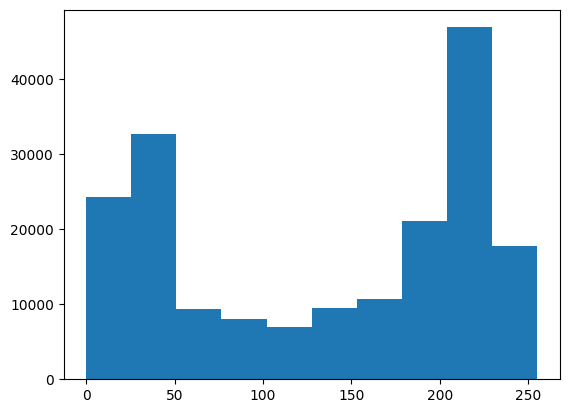

Histogram: [29862 31642  8887  6395  9749 11581 18713 44368 26303]
Bin Edges: [  0.        28.333332  56.666664  84.99999  113.33333  141.66666
 169.99998  198.33333  226.66666  254.99998 ]


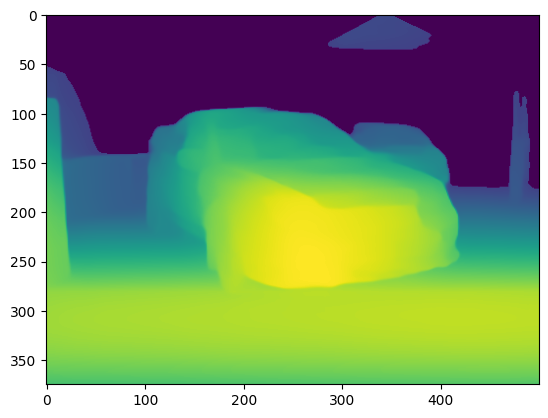

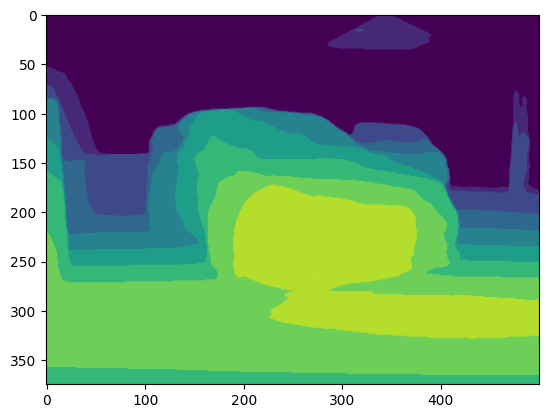

In [5]:
plt.imshow(depth_map)
plt.show()

# Assuming depth_map is your depth data array
bins, hist = create_dynamic_depth_bins(depth_map, overlap=0.2, peak_prominence=0.05, bin_width=0.1)

print("Bins:", bins)

plt.hist(depth_map.flatten(), bins=10)
plt.show()

# Calculate histogram with a sufficient range to cover all values
hist_range = (0, depth_map.max())  # Adjust the range based on max pixel value
hist, bin_edges = np.histogram(depth_map, bins=9, range=hist_range)

print("Histogram:", hist)
print("Bin Edges:", bin_edges)

segmented_map = depth_map.copy()
# let's assign 0 to values below 50
segmented_map[segmented_map < 50] = 0

#segmented_map = np.zeros_like(depth_map)
#for i, bin in enumerate(bins):
#    mask = (depth_map >= bin)
#    segmented_map[mask] = i + 1  # Assign a unique label for each bin
    
plt.imshow(segmented_map)
plt.show()

# let's convert segmented_map to 9 gray levels
segmented_map = cv2.normalize(segmented_map, None, 0, 9, cv2.NORM_MINMAX)
segmented_map = segmented_map.astype(np.uint8)

plt.imshow(segmented_map)
plt.show()



unique values segmented_map: [0 1 2 3 4 5 6 7 8 9]


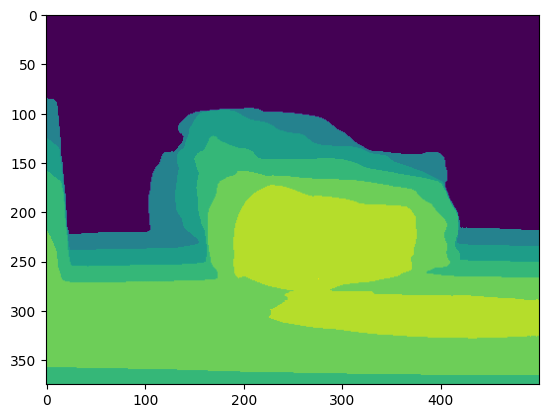

unique values simplified: [0 4 5 6 7 8 9]


In [6]:
print("unique values segmented_map:", np.unique(segmented_map))

simplified = segmented_map.copy()

# pixels with values 0, 1, 2, 3 are set to 0
simplified[simplified < 4] = 0

plt.imshow(simplified)
plt.show()

print("unique values simplified:", np.unique(simplified))


/Users/fedegonzal/Documents/ub/scope/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


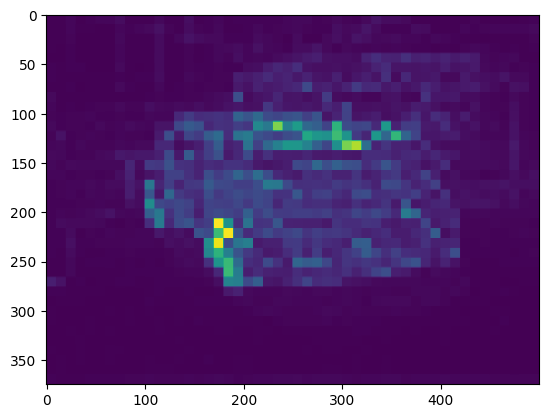

In [7]:
from myutils.dino1 import load_dino1_model
from myutils.dino2 import load_dino2_model
from myutils.discovery import *
from myutils.pascal_voc import *
from myutils.ssl import *
from myutils.utils import *
from myutils.datasets import bbox_iou

# dino v1
params = {
    'patch_size': 16,
    'ssl_checkpoint': 'pretrained/dino_deitsmall16_pretrain.pth',
#    'depth_checkpoint': 'Intel/dpt-hybrid-midas',
    'depth_checkpoint': 'Intel/dpt-beit-base-384',
    'img_size': None
}

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read an image
pil_img = load_image_as_pil(image_path)

# Convert to tensor and transform
img_tensor = load_image_as_tensor(pil_img).to(device)

# Padding the image with zeros to fit multiple of patch-size
patch_size = params['patch_size']
img_paded = img_tensor_padded(img_tensor, patch_size).to(device)

# Load the SSL model
model = load_dino1_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
#model = load_dino2_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
model.to(device)
model.eval()

# Get the attentions
atts = get_attentions(model, img_paded, patch_size)

# Obtain the attention map

# Sum the attention outputs (6 outputs used in DINO)
#sum_atts = atts.sum(0)
sum_atts = atts.max(0)

# resize the attention map to the original image size
# resize the image to the original size
sum_atts = cv2.resize(sum_atts, (image.size[0], image.size[1]))

# Normalize the attention map to 0-1
atts_norm = sum_atts / np.max(sum_atts)


plt.imshow(atts_norm)
plt.show()


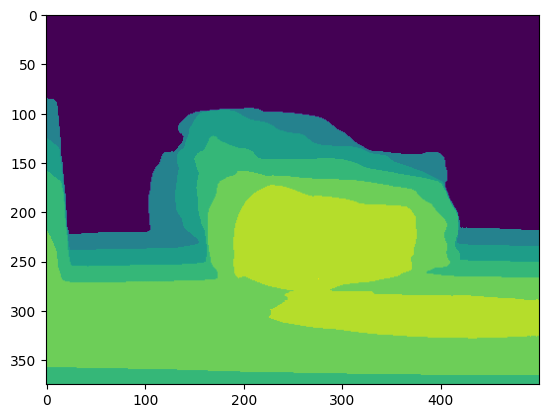

atts_norm 0.0035693673 1.0
depth_norm 0.0 1.0


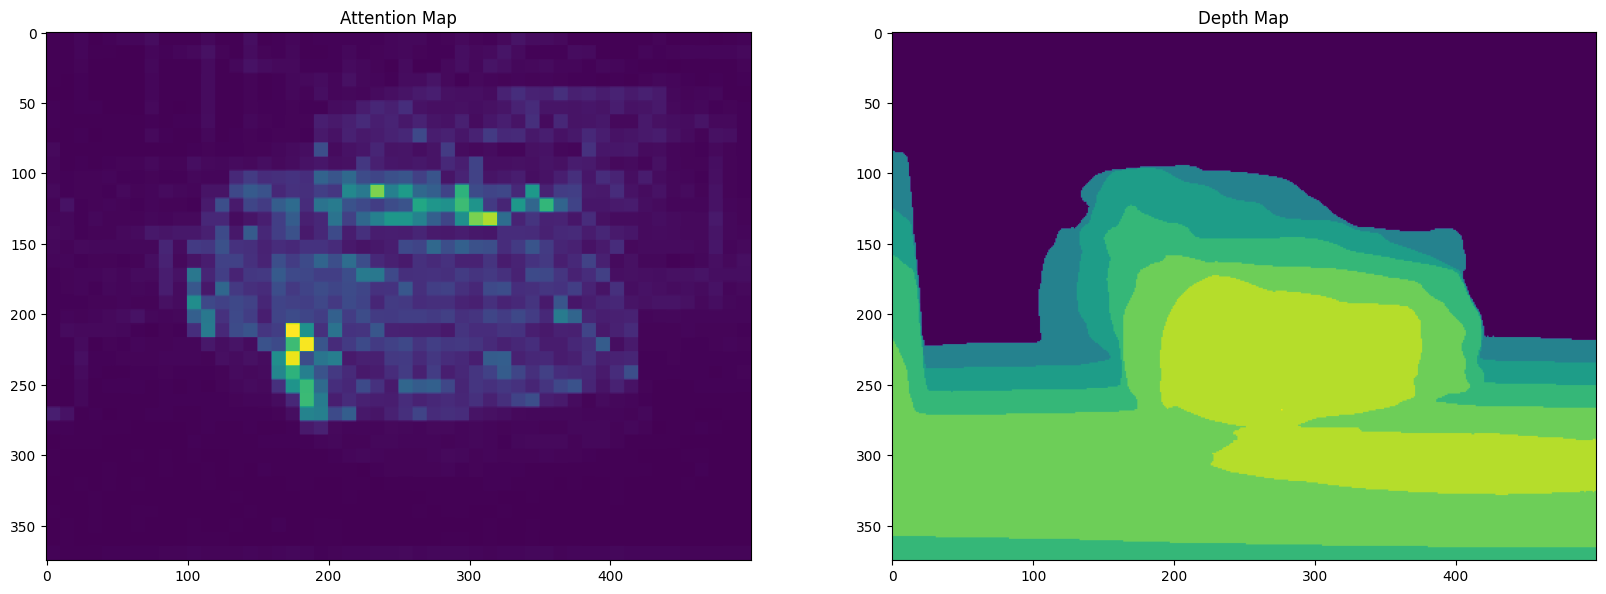

In [8]:

plt.imshow(simplified)
plt.show()

# normalize simplified to 0-1
depth_norm = simplified / np.max(simplified)

print("atts_norm", atts_norm.min(), atts_norm.max())
print("depth_norm", depth_norm.min(), depth_norm.max())

# plt grid 1x2
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# plot the attention map
axs[0].imshow(atts_norm)
axs[0].set_title('Attention Map')

# plot the depth map
axs[1].imshow(depth_norm)
axs[1].set_title('Depth Map')

plt.show()


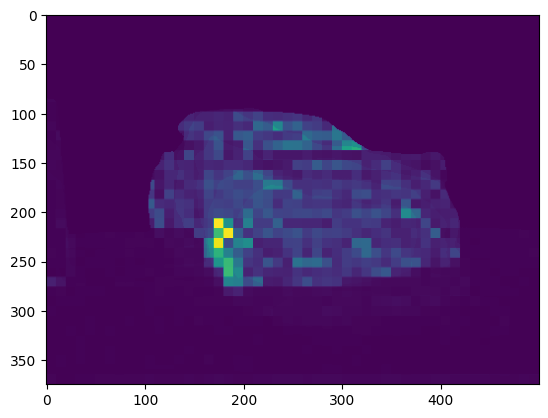

Found 0 peaks in the histogram.
Bins: []


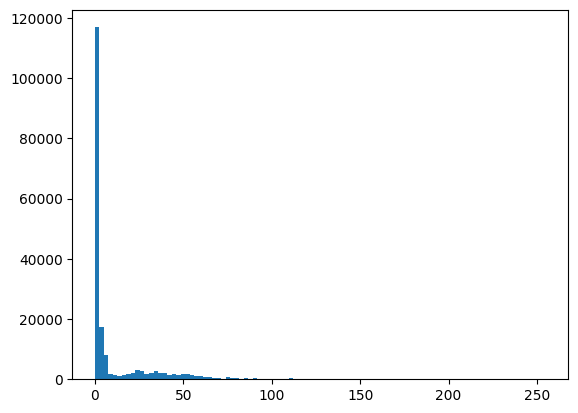

In [9]:
att_depth = (atts_norm * 1.3) * depth_norm

# normalize simplified from 0 to 255
att_depth = cv2.normalize(att_depth, None, 0, 255, cv2.NORM_MINMAX)


plt.imshow(att_depth)
plt.show()

# Assuming att_depth is your depth data array
bins, hist = create_dynamic_depth_bins(att_depth, overlap=0.2, peak_prominence=0.05, bin_width=0.1, bins=100)

print("Bins:", bins)

plt.hist(att_depth.flatten(), bins=100)
plt.show()



0.0 11.633360384249896 254.99999999999997 24.21365982036251


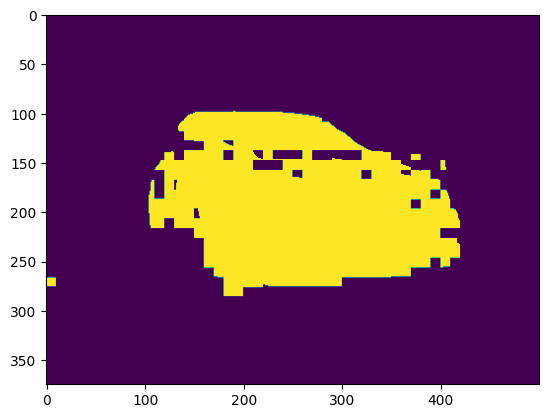

In [10]:
print(att_depth.min(), att_depth.mean(), att_depth.max(), att_depth.std())

att_depth_masked = att_depth.copy()

#threshold = att_depth.mean()
#threshold = att_depth.std()
threshold = (att_depth.mean() + att_depth.std()) / 2

att_depth_masked[att_depth_masked <= threshold] = 0
att_depth_masked[att_depth_masked > threshold] = 255

att_depth_masked[att_depth_masked <= threshold] = 0
att_depth_masked[att_depth_masked > threshold] = 255

plt.imshow(att_depth_masked)
plt.show()


In [11]:
import numpy as np

# Define IoU calculation
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    # Calculate the area of intersection rectangle
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # Calculate the area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    # Calculate the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

# Apply Non-Maximum Suppression (NMS)
def non_maximum_suppression(boxes, iou_threshold=0.5):
    boxes = sorted(boxes, key=lambda x: x[2] * x[3], reverse=True)  # Sort by area
    filtered_boxes = []
    
    while boxes:
        # Select the box with the largest area (or confidence if available)
        current_box = boxes.pop(0)
        filtered_boxes.append(current_box)
        
        # Filter out boxes that have a high IoU with the current box
        boxes = [box for box in boxes if calculate_iou(current_box, box) < iou_threshold]
    
    return filtered_boxes


In [12]:
colors = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (128, 0, 128),  # Purple
    (0, 255, 255),  # Cyan
    (255, 20, 147), # Pink
    (0, 128, 0),    # Dark Green
    (139, 69, 19)   # Brown
]


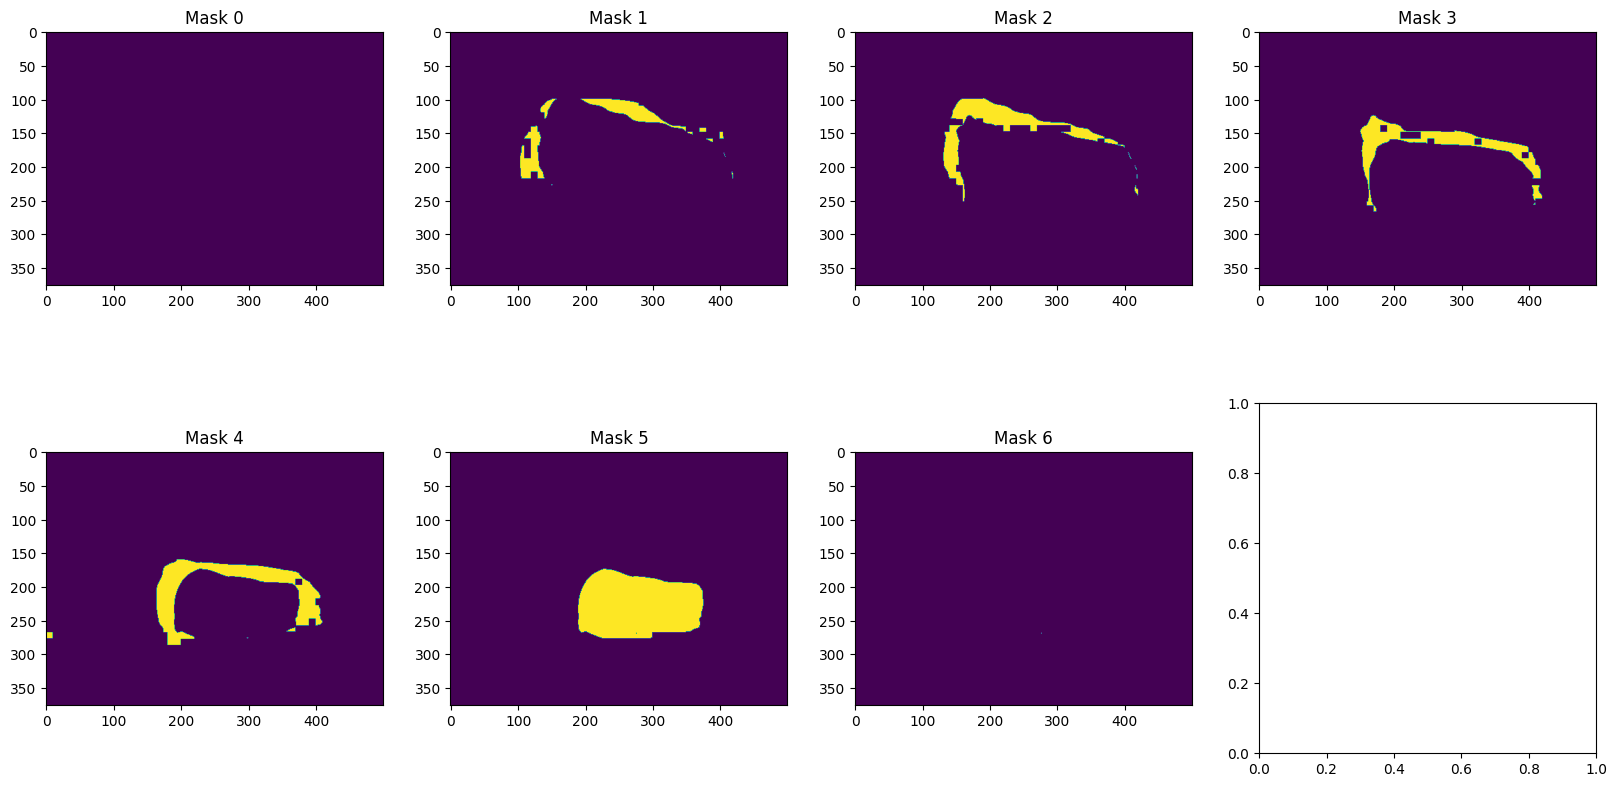

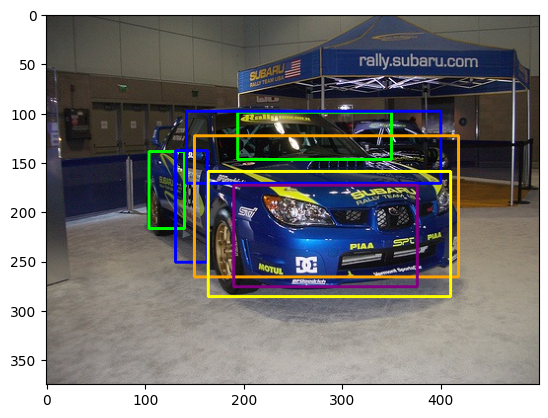

Proposed bounding boxes: [[104, 98, 316, 188], [194, 99, 156, 48], [104, 139, 36, 78], [142, 98, 258, 73], [131, 138, 32, 113], [150, 123, 268, 143], [164, 159, 246, 127], [190, 173, 186, 103]]
Filtered bounding boxes: [[104, 98, 316, 188], [194, 99, 156, 48], [131, 138, 32, 113], [104, 139, 36, 78]]


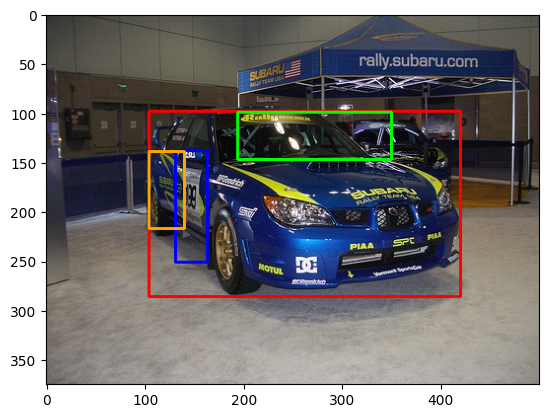

In [13]:
final_image = image.copy()

# convert final_image to numpy array
final_image = np.array(final_image)
final_image_loop = final_image.copy()


unique_values = np.unique(simplified)

prposed_boxes = get_boxes(att_depth_masked)


# let's create a mask for each unique value in simplified
#
# let's plt a grid with the masks
fig, axs = plt.subplots(2, int(len(unique_values) / 2) + 1, figsize=(20, 10))

for i, value in enumerate(unique_values):
    # create a mask for the current value
    mask = np.zeros_like(simplified)
    mask[simplified == value] = 255

    mask = mask * att_depth_masked

    # assign 255 to pixels with values greater than 0
    #mask[mask > 0] = 255

    # plot the mask
    grid_i = i // (len(unique_values) // 2 + 1)  # Row index (0 or 1)
    grid_j = i % (len(unique_values) // 2 + 1)   # Column index

    axs[grid_i, grid_j].imshow(mask)
    axs[grid_i, grid_j].set_title(f"Mask {i}")

    #plt.imshow(mask)
    #plt.show()

    # let's implement morphological Dilation and Erosion to remove noise
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=3)
    mask = cv2.erode(mask, kernel, iterations=3)

    # let's find the contours
    boxes = get_boxes(mask)
    filtered_boxes = non_maximum_suppression(boxes, iou_threshold=0.3)

    for box in filtered_boxes:
        x, y, w, h = box
        color = colors[int(i)] # cycle colors if more boxes than colors
        cv2.rectangle(final_image_loop, (x, y), (x+w, y+h), color, 2)

    # print(boxes)
    prposed_boxes.extend(filtered_boxes)

    # plt.imshow(mask)
    # plt.show()


# show the grid
plt.show()

# show the final image after loop
plt.imshow(final_image_loop)
plt.show()

print("Proposed bounding boxes:", prposed_boxes)

# remove duplicates boxes
filtered_boxes = non_maximum_suppression(prposed_boxes, iou_threshold=0.3)
print("Filtered bounding boxes:", filtered_boxes)

# Draw the filtered boxes on the image
for i, box in enumerate(filtered_boxes):
    x, y, w, h = box
    color = colors[i % len(colors)] # cycle colors if more boxes than colors
    cv2.rectangle(final_image, (x, y), (x+w, y+h), color, 2)

# Display the final image with bounding boxes
plt.imshow(final_image)
plt.show()


[[104, 98, 316, 188]]


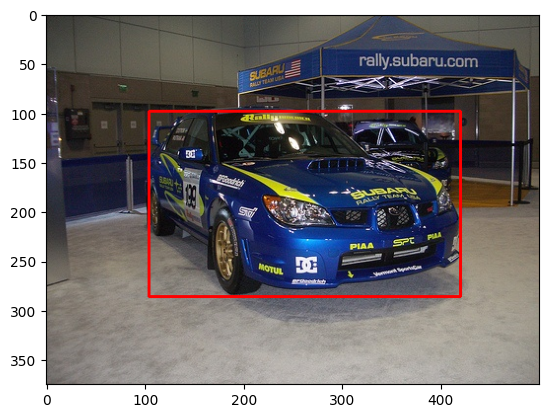

In [14]:
def filter_bounding_boxes(boxes):
    # Helper function to check if box1 is inside box2
    def is_inside(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        return (x1 >= x2 and y1 >= y2 and 
                (x1 + w1) <= (x2 + w2) and 
                (y1 + h1) <= (y2 + h2))
    
    # Result list for boxes that are not inside any other box
    result = []
    for i, box1 in enumerate(boxes):
        inside_any = False
        for j, box2 in enumerate(boxes):
            if i != j and is_inside(box1, box2):
                inside_any = True
                break
        if not inside_any:
            result.append(box1)
    return result


# Test with the given bounding boxes
final_final_image = image.copy()
final_final_image = np.array(final_final_image)
final_boxes = filter_bounding_boxes(filtered_boxes)
print(final_boxes)

for i, box in enumerate(final_boxes):
    x, y, w, h = box
    color = colors[i % len(colors)] # cycle colors if more boxes than colors
    cv2.rectangle(final_final_image, (x, y), (x+w, y+h), color, 2)

plt.imshow(final_final_image)
plt.show()
